# Examples

## Altitude Control of a Quadcopter

Imagine you have a quadcopter and you want the drone to hover at a certain altitude. The equations governing the relationship between thrust and altitude is given as the following:

$$ \ddot{z} = g - (\cos{\phi}\cos{\theta})\cdot\frac{u}{m} $$

Where *g* is the gravity, *u* is the thrust provided by the rotors and *m* is the mass of the quadcopter. Considering a perfectly horizontal quadcopter, pitch and roll are zero, and the equation reduces to:

$$ \ddot{z} = g - \frac{u}{m} $$

In [1]:
%matplotlib inline

import numpy as np
import pyadrc
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 7.5]

### Creating QuadAltitude

There are three variables, which initialize the mass of the quadcopter, the gravity and the sampling time.

You can leave the default setting in, or change it up to see how your controller performs under different settings.

Our quadcopter has a mass of 28 grams, the gravity acceleration is $9.807m/s^2$ and the sampling time is 1ms.

In [2]:
quad = pyadrc.QuadAltitude(dt=0.001, m=0.028, g=9.807)

### Creating StateSpace ADRC

If you already looked at Section **Introduction**, you already have a pretty good idea of how you should tune your ADRC. But, just in case, we'll go step-by-step:

When you create StateSpace ADRC, you need to pass the following arguments:

* **Order**
  * either first-order or second-order depending on the plant
* **Sampling time** $\Delta$
* **Modelling parameter** $b_0$
  * Check out the introduction to learn more about this parameter.
* **Settling time** $t_{settle}$
  * This is the approximate time it takes for the system output to reach the 5%-band of the reference signal, this property is fulfilled only for a perfect modelling parameter.
  * Places the controller poles and determines closed-loop bandwidth
* $k_{ESO}$
  * Places the observer poles, such that observer poles are k-times faster than the controller poles.

In [3]:
delta = 0.001
adrc = pyadrc.StateSpace(order=2, delta=delta, b0=1/0.028, t_settle=0.5, k_eso=10)

The controller we are designing is second-order with a modelling parameter $b_0$ of 1/0.028. The settling time is 500ms and the observer poles are 10 times faster than controller poles. The control loop is sampled with 1000Hz (i.e. sampling time is 1ms).

Lets select a reference altitude of 1 meter, after one second the new reference will be 2 meters. In total, we will simulate 3 seconds to observe the steady-state mode.

In [4]:
u = 0
r_1 = 1.
r_2 = 2.
counter =  0.
sample = 1000 * 3
_u, _y, _setpoint = [], [], []

r = r_1

### Control loop

Both classes have __call__() method implemented, which means in order to interact with the objects, you use the appropriate form. For more information please refer to the API.

First, we send the first signal to the quadcopter, read the output of the drone, feed it to our controller along with the previous control signal, the reference signal (also called a setpoint).

The boolean variable *zoh* implements a zero-order hold, which holds the current input constant as long as the next sampling instant has not been reached. For actual implementations, it should be True. For simulations, False is perfectly acceptable.

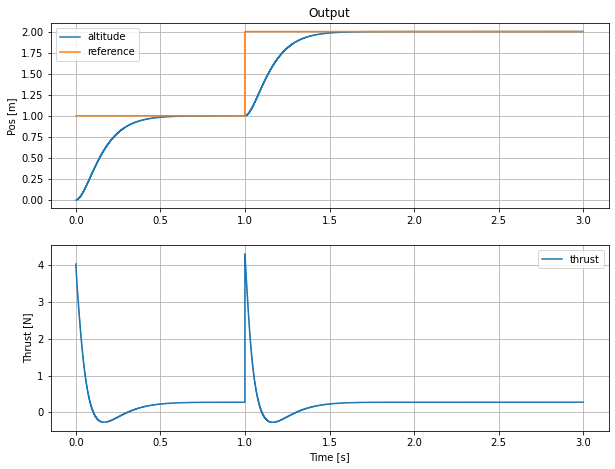

In [5]:
while counter <= sample:
    y = quad(u)
    u = adrc(y, u, r, zoh=False)

    _y.append(y)
    _u.append(u)
    _setpoint.append(r)

    counter = counter + 1
    
    if counter == 1000:
        r = r_2

# Create time vector
t = np.linspace(0, delta*sample, sample+1)

# Plot signals
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, _y, ds='steps', label='altitude')
plt.plot(t, _setpoint, ds='steps', label='reference')
plt.ylabel('Pos [m]')
plt.title('Output')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, _u, ds='steps', label='thrust')
plt.legend()
plt.ylabel('Thrust [N]')
plt.xlabel('Time [s]')
plt.grid()

The selected modelling parameter perfectly matches the plant that we wanted to control. Lets see what happens if we were 50% off of the actual value, i.e. $b_0 = 1/0.028/2$

In [6]:
adrc = pyadrc.StateSpace(order=2, delta=delta, b0=1/0.028/2, t_settle=0.5, k_eso=10)

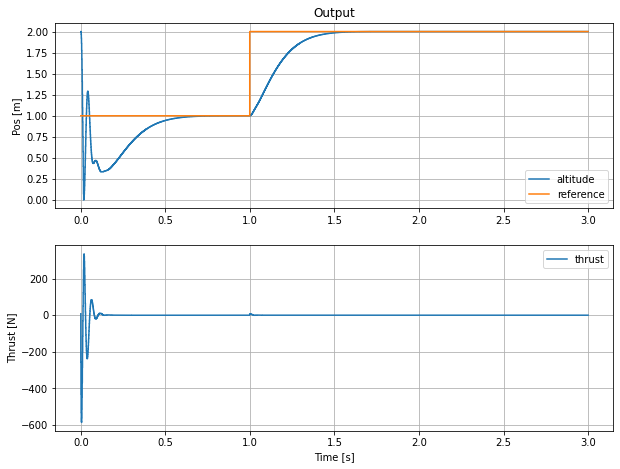

In [7]:
u = 0
r_1 = 1.
r_2 = 2.
counter =  0.
sample = 1000 * 3
_u, _y, _setpoint = [], [], []

r = r_1

while counter <= sample:
    y = quad(u)
    u = adrc(y, u, r, False)

    _y.append(y)
    _u.append(u)
    _setpoint.append(r)

    counter = counter + 1
    
    if counter == 1000:
        r = r_2

t = np.linspace(0, delta*sample, sample+1)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, _y, ds='steps', label='altitude')
plt.plot(t, _setpoint, ds='steps', label='reference')
plt.ylabel('Pos [m]')
plt.title('Output')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, _u, ds='steps', label='thrust')
plt.legend()
plt.ylabel('Thrust [N]')
plt.xlabel('Time [s]')
plt.grid()

In [8]:
adrc = pyadrc.StateSpace(order=2, delta=delta, b0=1/0.028/4, t_settle=0.5, k_eso=10)

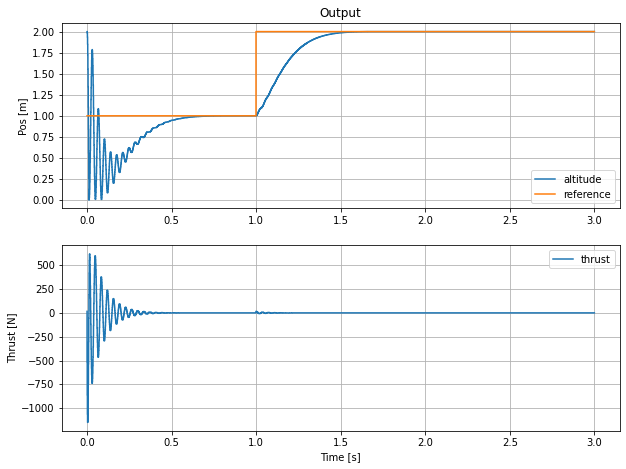

In [9]:
u = 0
r_1 = 1.
r_2 = 2.
counter =  0.
sample = 1000 * 3
_u, _y, _setpoint = [], [], []

r = r_1

while counter <= sample:
    y = quad(u)
    u = adrc(y, u, r, False)

    _y.append(y)
    _u.append(u)
    _setpoint.append(r)

    counter = counter + 1
    
    if counter == 1000:
        r = r_2

t = np.linspace(0, delta*sample, sample+1)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, _y, ds='steps', label='altitude')
plt.plot(t, _setpoint, ds='steps', label='reference')
plt.ylabel('Pos [m]')
plt.title('Output')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, _u, ds='steps', label='thrust')
plt.legend()
plt.ylabel('Thrust [N]')
plt.xlabel('Time [s]')
plt.grid()



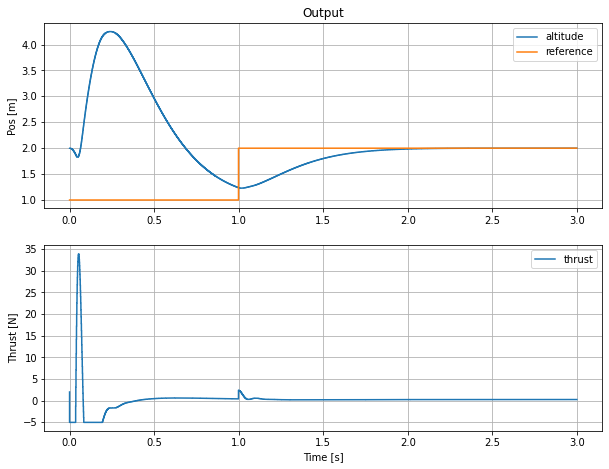

In [10]:
adrc = pyadrc.StateSpace(order=2, delta=delta, b0=1/0.028/2, t_settle=1, k_eso=10)

adrc.magnitude_limits = (-5, None)

u = 0
r_1 = 1.
r_2 = 2.
counter =  0.
sample = 1000 * 3
_u, _y, _setpoint = [], [], []

r = r_1

while counter <= sample:
    y = quad(u)
    u = adrc(y, u, r, False)

    _y.append(y)
    _u.append(u)
    _setpoint.append(r)

    counter = counter + 1
    
    if counter == 1000:
        r = r_2

t = np.linspace(0, delta*sample, sample+1)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, _y, ds='steps', label='altitude')
plt.plot(t, _setpoint, ds='steps', label='reference')
plt.ylabel('Pos [m]')
plt.title('Output')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, _u, ds='steps', label='thrust')
plt.legend()
plt.ylabel('Thrust [N]')
plt.xlabel('Time [s]')
plt.grid()